# Segumentação de produtos Baseado em Recência e Frequência

Recência, quão recente é a última venda, e Frequência quantas vendas em um determinado período.

Limitação em relação à sazonalidazde dos produtos precisa ser observada.

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore') #Desabilitar Warnings 

Recuperando dados

In [150]:
df =pd.read_csv('item_sales.csv')

In [151]:
df['store'].unique()

array(['Greenwich_Village', 'Harlem', 'Tribeca', 'Brooklyn', 'South_End',
       'Roxbury', 'Back_Bay', 'Midtown_Village', 'Yorktown',
       'Queen_Village'], dtype=object)

Funções:

In [232]:
def feature_creation(df):
    global data

    # Remove as colunas indesejadas do DataFrame
    df = df.drop('id', axis=1)
    df = df.drop('category', axis=1)
    df = df.drop('department', axis=1)
    df = df.drop('store', axis=1)
    df = df.drop('region', axis=1)
    df = df.drop('store_code', axis=1)

    # Cria uma nova coluna chamada 'frequencia' que é a soma das colunas restantes
    df['frequencia'] = df.iloc[:, 1:].sum(axis=1)

    # Encontra os índices das colunas 'd_1' e 'd_1913'
    d1 = df.columns.get_loc('d_1')
    d1913 = df.columns.get_loc('d_1913')

    recencia = []

    # Calcula a recência para cada linha
    for i in range(len(df)):
        found_non_zero = False
        for j in reversed(range(d1, d1913 + 1)):
            if df.iloc[i, j] != 0:
                recencia.append(d1913 - j + 1)
                found_non_zero = True
                break
        if not found_non_zero:
            recencia.append(0)

    # Cria uma nova coluna chamada 'recencia' com os valores calculados
    df['recencia'] = recencia

    # 
    drop_c = len(df.T) - 2
    df.drop(df.iloc[:, 1:drop_c], inplace=True, axis=1)

    # Exibe as primeiras linhas do DataFrame
    print(df.head())

    # Retorneao DataFrame
    data = pd.DataFrame(df)

def log_tranform_feat(df):
    global data

    # Aplique a transformação logarítmica nas colunas 'frequencia' e 'recencia' para melhoria da eficência do modelo
    df['frequencia_log'] = df['frequencia'].apply(lambda x: np.log1p(x))
    df['recencia_log'] = df['recencia'].apply(lambda x: np.log1p(x))

    data = pd.DataFrame(df)

def enc_categoricas(df):
    # Use o LabelEncoder para codificar a coluna 'item'
    label_encoder = LabelEncoder()
    df['item_enc'] = label_encoder.fit_transform(df['item'])
    return df

def ebow(dfc):
    sum_of_sqr_dist = {}

    # Execute o método Elbow para determinar o número ideal de clusters (K)
    for k in range(1, 10):
        km = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
        km = km.fit(dfc)
        sum_of_sqr_dist[k] = km.inertia_

    # Plote o gráfico do método Elbow
    sns.pointplot(x=list(sum_of_sqr_dist.keys()), y=list(sum_of_sqr_dist.values()))
    plt.xlabel("Número de Clusters (K)")
    plt.ylabel("Soma das Distâncias Quadradas")
    plt.title("Método Elbow para Determinar o K Ótimo")
    plt.show()

def model(dfc):
    # Crie e ajuste o modelo K-Means com o número desejado de clusters
    Model = KMeans(n_clusters=5, init='k-means++', max_iter=10000)
    Model.fit(dfc)
    return Model

In [153]:
def select_store(st_name): # Selecionar loja
    global data
    data = pd.DataFrame(df[df.store == st_name])

### Análise da Loja Tribeca

In [154]:
store_name = 'Tribeca'
select_store(store_name)

In [155]:
feature_creation(data)

                  item  frequencia  recencia
6098  ACCESORIES_1_001         758         1
6099  ACCESORIES_1_002         452         2
6100  ACCESORIES_1_003         137         1
6101  ACCESORIES_1_004       10442         1
6102  ACCESORIES_1_005        2663         1


In [97]:
log_tranform_feat(data)

In [98]:
data.head()

,item,frequencia,recencia,frequencia_log,recencia_log
6098,ACCESORIES_1_001,758,1,6.632002,0.693147
6099,ACCESORIES_1_002,452,2,6.115892,1.098612
6100,ACCESORIES_1_003,137,1,4.927254,0.693147
6101,ACCESORIES_1_004,10442,1,9.253687,0.693147
6102,ACCESORIES_1_005,2663,1,7.887584,0.693147


In [99]:
scaler = MinMaxScaler() # Escalonador MinMax para melhorar a eficencia do modelo

In [100]:
df_normalized = scaler.fit_transform(data[['frequencia_log','recencia_log']])

In [101]:
df_normalized

array([[0.42200407, 0.        ],
       [0.37056456, 0.06615464],
       [0.25209558, 0.        ],
       ...,
       [0.51522774, 0.        ],
       [0.47100784, 0.        ],
       [0.54368112, 0.        ]])

In [102]:
data_tribeca = enc_categoricas(data) #Codifica veriavel categórica

In [103]:
data_tribeca 

,item,frequencia,recencia,frequencia_log,recencia_log,item_enc
6098,ACCESORIES_1_001,758,1,6.632002,0.693147,0
6099,ACCESORIES_1_002,452,2,6.115892,1.098612,1
6100,ACCESORIES_1_003,137,1,4.927254,0.693147,2
6101,ACCESORIES_1_004,10442,1,9.253687,0.693147,3
6102,ACCESORIES_1_005,2663,1,7.887584,0.693147,4
...,...,...,...,...,...,...
9142,SUPERMARKET_3_823,4805,2,8.477620,1.098612,3044
9143,SUPERMARKET_3_824,1563,1,7.355002,0.693147,3045
9144,SUPERMARKET_3_825,1933,1,7.567346,0.693147,3046
9145,SUPERMARKET_3_826,1240,1,7.123673,0.693147,3047


In [104]:
data_tribeca_model = data_tribeca.drop(['item'], axis=1)


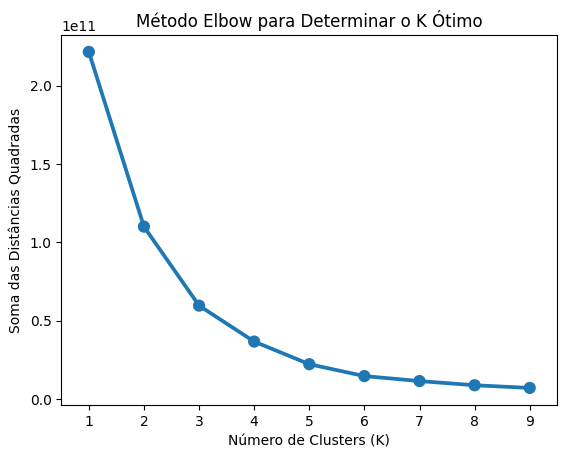

In [105]:
ebow(data_tribeca_model)

In [106]:
Model = model(df_normalized)

In [107]:
data_tribeca['cluster'] = Model.labels_

In [108]:
data_tribeca['cluster'].value_counts()

cluster
0    1197
1     649
3     610
4     429
2     164
Name: count, dtype: int64

<Axes: xlabel='cluster', ylabel='count'>

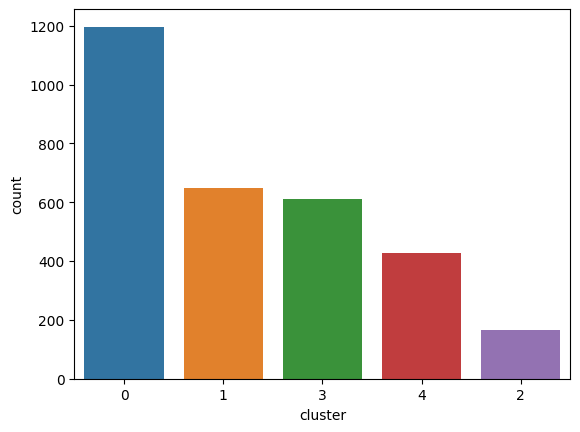

In [109]:
order= data_tribeca['cluster'].value_counts().index
sns.countplot(x=data_tribeca['cluster'],order=order)

## Interpretação dos Clusters

Dentro dos clusters, podem aparecer alguns produtos sazonais. Para identificá-los, é necessária uma avaliação mais detalhada.

In [110]:
data.sort_values(by='frequencia',ascending=False).head(10) #Top 10 frequências

,item,frequencia,recencia,frequencia_log,recencia_log,item_enc,cluster
8412,SUPERMARKET_3_090,250502,1,12.431226,0.693147,2314,3
8908,SUPERMARKET_3_586,134386,1,11.808479,0.693147,2810,3
8442,SUPERMARKET_3_120,88795,1,11.394097,0.693147,2344,3
8574,SUPERMARKET_3_252,81456,1,11.307831,0.693147,2476,3
8863,SUPERMARKET_3_541,80491,26,11.295913,3.295837,2765,3
8957,SUPERMARKET_3_635,80222,25,11.292566,3.258097,2859,3
9127,SUPERMARKET_3_808,72591,9,11.192610,2.302585,3029,3
8909,SUPERMARKET_3_587,70324,1,11.160883,0.693147,2811,3
8877,SUPERMARKET_3_555,59092,1,10.986868,0.693147,2779,3
9003,SUPERMARKET_3_681,55537,1,10.924823,0.693147,2905,3


In [111]:
data.sort_values(by='frequencia',ascending=True).head(10) #Botton 10 frequências

,item,frequencia,recencia,frequencia_log,recencia_log,item_enc,cluster
6682,HOME_&_GARDEN_1_020,10,7,2.397895,2.079442,584,4
6992,HOME_&_GARDEN_1_336,18,75,2.944439,4.330733,894,2
6733,HOME_&_GARDEN_1_073,19,7,2.995732,2.079442,635,4
6149,ACCESORIES_1_052,32,38,3.496508,3.663562,51,2
7590,HOME_&_GARDEN_2_397,34,5,3.555348,1.791759,1492,4
7165,HOME_&_GARDEN_1_512,34,2,3.555348,1.098612,1067,1
7787,SUPERMARKET_1_079,40,19,3.713572,2.995732,1689,4
6624,ACCESORIES_2_111,43,95,3.784190,4.564348,526,2
6540,ACCESORIES_2_027,43,1,3.784190,0.693147,442,1
6934,HOME_&_GARDEN_1_278,47,1,3.871201,0.693147,836,1


In [112]:
top_ten_tribeca = ['SUPERMARKET_3_090','SUPERMARKET_3_586','SUPERMARKET_3_120','SUPERMARKET_3_252','SUPERMARKET_3_541','SUPERMARKET_3_635','SUPERMARKET_3_808','SUPERMARKET_3_587','SUPERMARKET_3_555','SUPERMARKET_3_681']
botton_ten_tribeca = ['HOME_&_GARDEN_1_020','HOME_&_GARDEN_1_336','HOME_&_GARDEN_1_073','ACCESORIES_1_052','HOME_&_GARDEN_2_397','HOME_&_GARDEN_1_512','SUPERMARKET_1_079','ACCESORIES_2_111','ACCESORIES_2_027','HOME_&_GARDEN_1_278']
 
for iten in top_ten_tribeca:
    linha = data_tribeca[['item', 'cluster']][data_tribeca.item == iten]
    print(linha)

for iten in botton_ten_tribeca:
    linha = data_tribeca[['item', 'cluster']][data_tribeca.item == iten]
    print(linha)

                   item  cluster
8412  SUPERMARKET_3_090        3
                   item  cluster
8908  SUPERMARKET_3_586        3
                   item  cluster
8442  SUPERMARKET_3_120        3
                   item  cluster
8574  SUPERMARKET_3_252        3
                   item  cluster
8863  SUPERMARKET_3_541        3
                   item  cluster
8957  SUPERMARKET_3_635        3
                   item  cluster
9127  SUPERMARKET_3_808        3
                   item  cluster
8909  SUPERMARKET_3_587        3
                   item  cluster
8877  SUPERMARKET_3_555        3
                   item  cluster
9003  SUPERMARKET_3_681        3
                     item  cluster
6682  HOME_&_GARDEN_1_020        4
                     item  cluster
6992  HOME_&_GARDEN_1_336        2
                     item  cluster
6733  HOME_&_GARDEN_1_073        4
                  item  cluster
6149  ACCESORIES_1_052        2
                     item  cluster
7590  HOME_&_GARDEN_2_397      

__Cluster 0 - : Demais Itens:__
Cluster com frequência média e baixa recência: esses são produtos comuns, devendo ser a maioria dos produtos.

__Cluster 1 - Itens Ganhando ou perdendo porpularidade:__
Cluster com recência média e uma ampla variação na frequência: eles podem ser produtos emergentes (parte inferior esquerda do cluster) ou produtos em declínio (parte superior direita do cluster).

__Cluster 2 - Itens de baixa popularidade:__
Cluster com alta recência e uma ampla variação na frequência: eles podem ser produtos ruins que nunca venderam (parte inferior do cluster) ou produtos antigos (parte esquerda do cluster) que costumavam vender, mas agora não vendem mais.

__Cluster 3 - Itens Mais Populares:__
Cluster com alta frequência e baixa recência: esses são os produtos mais quentes/melhor vendidos.

__Cluster 4 - Itens Novos:__
Cluster com baixa frequência e baixa recência: são produtos novos/que estão aparecendo.

### Análise da Loja Brooklyn

In [233]:
store_name = 'Brooklyn'
select_store(store_name)

In [234]:
feature_creation(data)

                  item  frequencia  recencia
9147  ACCESORIES_1_001         635         1
9148  ACCESORIES_1_002         323         1
9149  ACCESORIES_1_003         161         3
9150  ACCESORIES_1_004        1588         2
9151  ACCESORIES_1_005         930         1


In [235]:
log_tranform_feat(data)

In [236]:
df_normalized = scaler.fit_transform(data[['frequencia_log','recencia_log']])

In [237]:
df_normalized

array([[0.43966859, 0.        ],
       [0.35395112, 0.        ],
       [0.26585804, 0.11556893],
       ...,
       [0.52266509, 0.06760349],
       [0.57468067, 0.        ],
       [0.19668196, 0.        ]])

In [238]:
data_brooklyn = enc_categoricas(data) 

In [239]:
data_brooklyn_model = data_brooklyn .drop(['item'], axis=1)

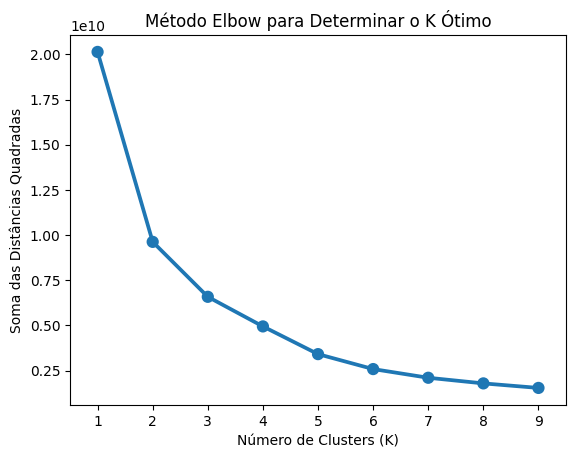

In [240]:
ebow(data_brooklyn_model)

In [241]:
Model = model(df_normalized)

In [242]:
data_brooklyn['cluster'] = Model.labels_

In [243]:
data_brooklyn['cluster'].value_counts()

cluster
4    1141
2     613
1     560
0     554
3     181
Name: count, dtype: int64

In [244]:
data.sort_values(by='frequencia',ascending=False).head(10)

,item,frequencia,recencia,frequencia_log,recencia_log,item_enc,cluster
11461,SUPERMARKET_3_090,52264,1,10.864082,0.693147,2314,0
11957,SUPERMARKET_3_586,32557,1,10.390778,0.693147,2810,0
11958,SUPERMARKET_3_587,24333,1,10.099630,0.693147,2811,0
11623,SUPERMARKET_3_252,23417,1,10.061260,0.693147,2476,0
12176,SUPERMARKET_3_808,21282,26,9.965664,3.295837,3029,0
12006,SUPERMARKET_3_635,20895,26,9.947313,3.295837,2859,0
12084,SUPERMARKET_3_714,19265,1,9.866097,0.693147,2937,0
11573,SUPERMARKET_3_202,18558,1,9.828710,0.693147,2426,0
11862,SUPERMARKET_3_491,18533,1,9.827362,0.693147,2715,0
11912,SUPERMARKET_3_541,17811,29,9.787628,3.401197,2765,0


In [245]:
data.sort_values(by='frequencia',ascending=True).head(10)

,item,frequencia,recencia,frequencia_log,recencia_log,item_enc,cluster
10458,HOME_&_GARDEN_2_216,19,2,2.995732,1.098612,1311,2
10214,HOME_&_GARDEN_1_512,20,21,3.044522,3.091042,1067,1
10549,HOME_&_GARDEN_2_307,21,7,3.091042,2.079442,1402,1
10102,HOME_&_GARDEN_1_400,22,1,3.135494,0.693147,955,2
9890,HOME_&_GARDEN_1_183,22,6,3.135494,1.945910,743,1
9208,ACCESORIES_1_063,24,1,3.218876,0.693147,61,2
9152,ACCESORIES_1_006,25,1,3.258097,0.693147,5,2
9587,ACCESORIES_2_025,28,21,3.367296,3.091042,440,1
9646,ACCESORIES_2_084,28,64,3.367296,4.174387,499,3
9369,ACCESORIES_1_230,28,2,3.367296,1.098612,222,2


<Axes: xlabel='cluster', ylabel='count'>

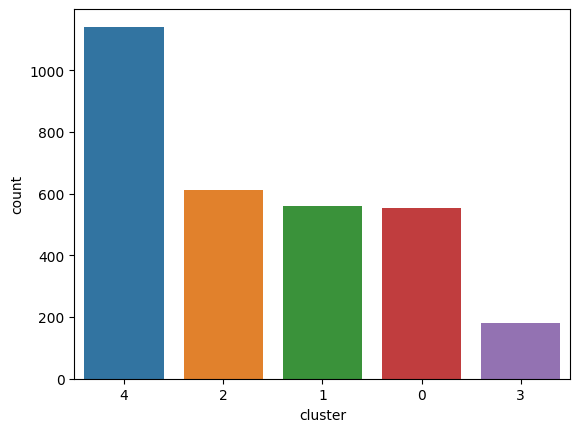

In [246]:
order = data_brooklyn['cluster'].value_counts().index
sns.countplot(x=data_brooklyn['cluster'],order=order)

__Cluster 0 - : Demais Itens:__
Cluster com frequência média e baixa recência: esses são produtos comuns, devendo ser a maioria dos produtos.

__Cluster 1 - Itens Ganhando ou perdendo porpularidade:__
Cluster com recência média e uma ampla variação na frequência: eles podem ser produtos emergentes (parte inferior esquerda do cluster) ou produtos em declínio (parte superior direita do cluster).

__Cluster 2 - Itens de baixa popularidade:__
Cluster com alta recência e uma ampla variação na frequência: eles podem ser produtos ruins que nunca venderam (parte inferior do cluster) ou produtos antigos (parte esquerda do cluster) que costumavam vender, mas agora não vendem mais.

__Cluster 3 - Itens Mais Populares:__
Cluster com alta frequência e baixa recência: esses são os produtos mais quentes/melhor vendidos.

__Cluster 4 - Itens Novos:__
Cluster com baixa frequência e baixa recência: são produtos novos/que estão aparecendo.